![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Optimizing parameters for open-loop flow control

In this notebook, we cover the following topics:

- Black-box hyperparameter optimization
- Gaussian processes
- Bayesian optimization (BayesOpt)

The content of this notebook relies heavily on the following sources:

- C. M. Bishop: Pattern recognition and machine learning
- J. Görtler et al.: [A visual exploration of Gaussian processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- A. Damianou: [Gaussian process lecture](https://nbviewer.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb)
- Q. Nguyen: [Bayesian optimization in action](https://www.manning.com/books/bayesian-optimization-in-action?ar=true&lpse=A)

## Black-box hyperparameter optimization

Refer to the exercise on open-loop control.

In [1]:
from os import makedirs
from os.path import join
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
import gpytorch
import botorch

# make results reproducible
pt.manual_seed(0)

# plot resolution and rendering
plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{{amsmath}}"
plt.style.use("dark_background")

# create output directory
output = join("output", "bayes_opt")
makedirs(output, exist_ok=True)

## The normal (Gussian) distribution

The normal distribution of a random variable $x$ with mean $\mu_x$ and variance $\sigma_x^2$ is denoted as:
$$
    X \sim \mathcal{N}(\mu_X, \sigma_X^2)
$$
The accompanying propability density function reads:
$$
p_X(x) = \frac{1}{\sqrt{2\pi \sigma_X^2}} \exp\left(-\frac{1}{2}\left(\frac{x - \mu_X}{\sigma_X}\right)^2\right)
$$

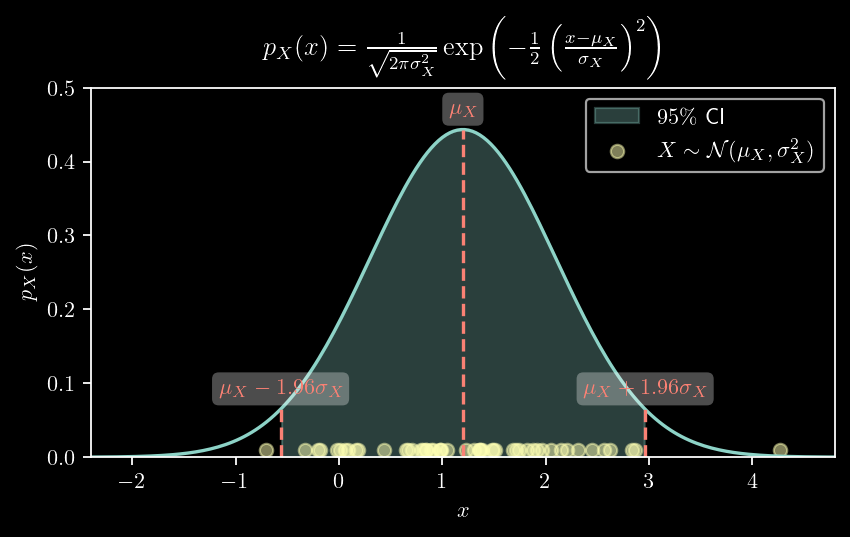

In [2]:
pt.manual_seed(0)
fig, ax = plt.subplots(figsize=(6, 3))

mu, sig = 1.2, 0.9
x = pt.linspace(mu-4*sig, mu+4*sig, 200)
normal = pt.distributions.Normal(mu, sig)
pdf = normal.log_prob(x).exp()
ax.fill_between(x, pdf, where=(x >= mu - 1.96*sig) & (x <= mu + 1.96*sig), color="C0", alpha=0.3, label=r"$95\%$ CI")
samples = normal.sample((50,))
ax.scatter(samples, [0.01]*len(samples), marker="o", c="C1", alpha=0.5, label=r"$X \sim \mathcal{N}(\mu_X, \sigma_X^2)$")
ax.plot(x, pdf, c="C0")
ax.plot([mu]*2, [0, normal.log_prob(pt.tensor(mu)).exp().item()], c="C3", ls="--")
ax.plot([mu-1.96*sig]*2, [0, normal.log_prob(pt.tensor(mu-1.96*sig)).exp().item()], c="C3", ls="--")
ax.plot([mu+1.96*sig]*2, [0, normal.log_prob(pt.tensor(mu+1.96*sig)).exp().item()], c="C3", ls="--")
ax.text(
    mu, normal.log_prob(pt.tensor(mu)).exp().item()+0.02, r"$\mu_X$", c="C3", ha="center",
    bbox=dict(facecolor="white", alpha=0.3, edgecolor="none", boxstyle="round,pad=0.3")
)
ax.text(
    mu-1.96*sig, normal.log_prob(pt.tensor(mu-1.96*sig)).exp().item()+0.02, r"$\mu_X-1.96\sigma_X$", c="C3", ha="center",
    bbox=dict(facecolor="white", alpha=0.3, edgecolor="none", boxstyle="round,pad=0.3")
)
ax.text(
    mu+1.96*sig, normal.log_prob(pt.tensor(mu+1.96*sig)).exp().item()+0.02, r"$\mu_X+1.96\sigma_X$", c="C3", ha="center",
    bbox=dict(facecolor="white", alpha=0.3, edgecolor="none", boxstyle="round,pad=0.3")
)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p_X(x)$")
ax.set_xlim(x[0], x[-1])
ax.set_ylim(0, 0.5)
ax.legend()
ax.set_title(r"$p_X(x) = \frac{1}{\sqrt{2\pi \sigma_X^2}} \exp\left(-\frac{1}{2}\left(\frac{x - \mu_X}{\sigma_X}\right)^2\right)$", pad=15)
plt.savefig(join(output, "uvp_gaussian.svg"), bbox_inches="tight", transparent=True)

## Multivariate Gaussian distributions

Given a vector of random variables $\mathbf{x} \in \mathbb{R}^d$, the corresponding multivariate Gaussian distribution is (equation 2.43 in *Bishop*):
$$
  p(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^d \mathrm{det}(\mathbf{\Sigma})}}\mathrm{exp}\left( -\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu}) \right),
$$
where $\mathbf{\mu} \in \mathbb{R}^{d}$ is the mean vector and $\mathbf{\Sigma}\in \mathbb{R}^{d\times d}$ is the covariance matrix.

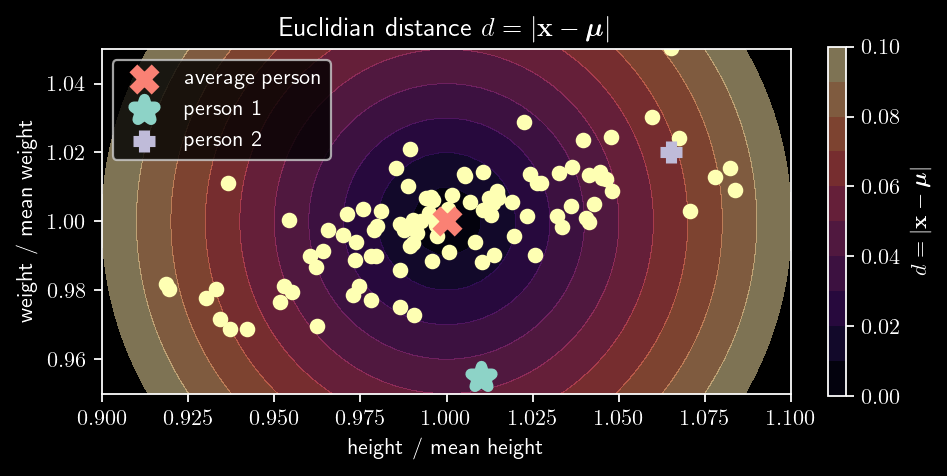

In [3]:
pt.manual_seed(0)
fig, ax = plt.subplots(figsize=(6, 3))

x_h, x_w = pt.linspace(0.8, 1.2, 100), pt.linspace(0.9, 1.1, 100)
xx1, xx2 = pt.meshgrid(x_h, x_w, indexing="ij")
mean = pt.tensor([165.0, 69.2])
cov = pt.tensor([[50.0, 5.0], [5.0, 1.0]])
dist = (pt.vstack((xx1.flatten(), xx2.flatten())).T - pt.ones(2)).norm(dim=1).reshape(xx1.shape)
levels = pt.linspace(0, 0.1, 11)
cont = ax.contourf(x_h, x_w, dist.T, levels=levels, vmin=0, vmax=0.1, cmap="magma", alpha=0.5)
cbar = plt.colorbar(cont, ax=ax, fraction=0.0235, label=r"$d = |\mathbf{x}-\boldsymbol{\mu}|$")
normal = pt.distributions.multivariate_normal.MultivariateNormal(mean, cov)
samples = normal.sample((100,))
ax.scatter(samples[:, 0]/mean[0], samples[:, 1]/mean[1], marker="o", c="C1")
ax.scatter([1], [1], marker="x", s=100, lw=5, c="C3", label="average person")
ax.scatter([1.01], [0.955], marker="*", s=100, lw=5, c="C0", label="person 1")
ax.scatter([1.065], [1.02], marker="+", s=100, lw=5, c="C2", label="person 2")
ax.set_xlabel(r"height / mean height")
ax.set_ylabel(r"weight / mean weight")
ax.set_xlim(0.9, 1.1)
ax.set_ylim(0.95, 1.05)
ax.set_aspect("equal")
ax.set_title(r"Euclidian distance $d = |\mathbf{x}-\boldsymbol{\mu}|$")
ax.legend()
plt.savefig(join(output, "euclidian_distance_dist.svg"), bbox_inches="tight", transparent=True)

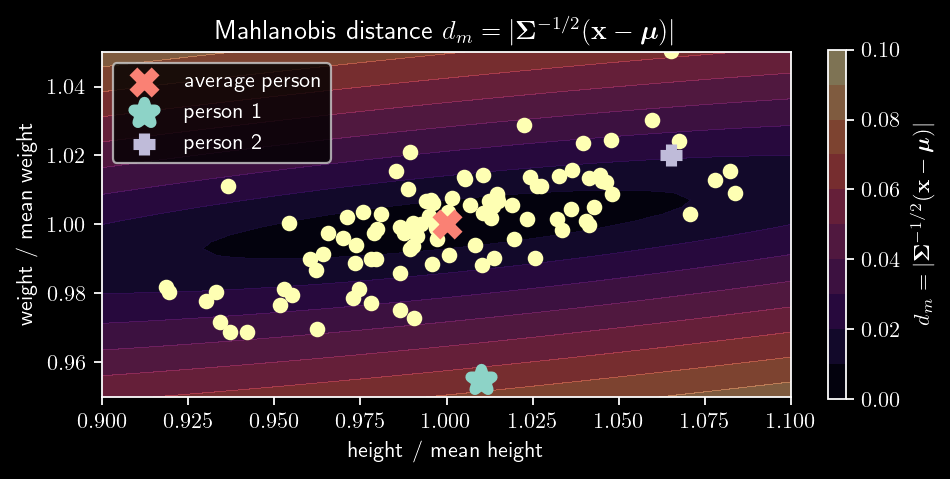

In [4]:
pt.manual_seed(0)
fig, ax = plt.subplots(figsize=(6, 3))

x_h, x_w = pt.linspace(0.8, 1.2, 100), pt.linspace(0.9, 1.1, 100)
xx1, xx2 = pt.meshgrid(x_h, x_w, indexing="ij")
mean = pt.tensor([165.0, 69.2])
cov = pt.tensor([[50.0, 5.0], [5.0, 1.0]])
e_val, e_vec = pt.linalg.eigh(cov)
cov_inv_sqrt = e_vec @ pt.diag(pt.sqrt(1.0/e_val)) @ e_vec.T
dist_vec = (pt.vstack((xx1.flatten(), xx2.flatten())).T - pt.ones(2)).T
m_dist = (cov_inv_sqrt @ dist_vec).norm(dim=0).reshape(xx1.shape)
levels = pt.linspace(0, 0.1, 11)
cont = ax.contourf(x_h, x_w, m_dist.T, levels=levels, vmin=0, vmax=0.1, cmap="magma", alpha=0.5)
cbar = plt.colorbar(cont, ax=ax, fraction=0.0235, label=r"$d_m = |\mathbf{\Sigma}^{-1/2}(\mathbf{x}-\boldsymbol{\mu})|$")

normal = pt.distributions.multivariate_normal.MultivariateNormal(mean, cov)
samples = normal.sample((100,))
ax.scatter(samples[:, 0]/mean[0], samples[:, 1]/mean[1], marker="o", c="C1")
ax.scatter([1], [1], marker="x", s=100, lw=5, c="C3", label="average person")
ax.scatter([1.01], [0.955], marker="*", s=100, lw=5, c="C0", label="person 1")
ax.scatter([1.065], [1.02], marker="+", s=100, lw=5, c="C2", label="person 2")
ax.set_xlabel(r"height / mean height")
ax.set_ylabel(r"weight / mean weight")
ax.set_xlim(0.9, 1.1)
ax.set_ylim(0.95, 1.05)
ax.set_aspect("equal")
ax.set_title(r"Mahlanobis distance $d_m = |\mathbf{\Sigma}^{-1/2}(\mathbf{x}-\boldsymbol{\mu})|$")
ax.legend()
plt.savefig(join(output, "mahalanobis_distance_dist.svg"), bbox_inches="tight", transparent=True)

In [5]:
def plot_mvg_pdf(ax, mean, cov, x1, x2, vmax):
    mvg = pt.distributions.multivariate_normal.MultivariateNormal(pt.tensor(mean), pt.tensor(cov))
    XT = pt.vstack((x1.flatten(), x2.flatten())).T
    p = mvg.log_prob(XT).exp().reshape(x1.shape)
    levels = pt.linspace(0, vmax, 15)
    ax.contourf(x1, x2, p, vmin=0, vmax=vmax, levels=levels, cmap="magma", extend="both")
    ax.set_aspect("equal")

In [6]:
x_plot = pt.linspace(-4, 4, 50)
xx1, xx2 = pt.meshgrid(x_plot, x_plot, indexing="ij")

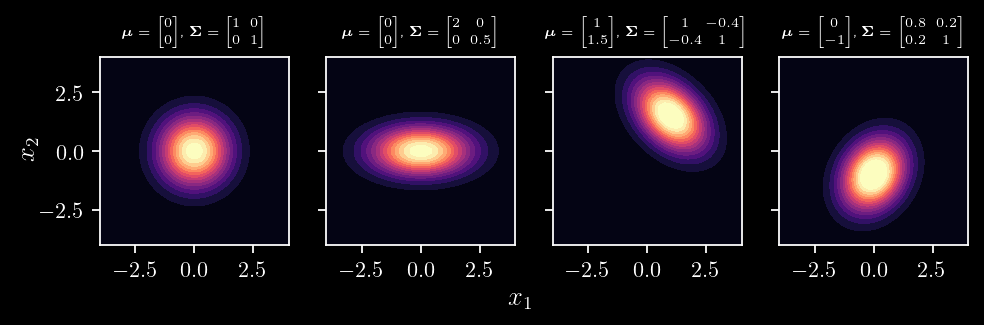

In [7]:
fig, axarr = plt.subplots(1, 4, figsize=(7, 2.5), sharex=True, sharey=True)

axarr[0].set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 0 \\ 0  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 1 &\hspace{-0.2cm} 0 \\ 0 &\hspace{-0.2cm} 1  \end{bmatrix}$", fontsize=6, pad=10)
plot_mvg_pdf(axarr[0], [0.0, 0.0], [[1, 0.0], [0.0, 1]], xx1, xx2, 0.15)
axarr[1].set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 0 \\ 0  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 2 &\hspace{-0.2cm} 0 \\ 0 &\hspace{-0.2cm} 0.5  \end{bmatrix}$", fontsize=6, pad=10)
plot_mvg_pdf(axarr[1], [0.0, 0.0], [[2, 0.0], [0.0, 0.5]], xx1, xx2, 0.15)
axarr[2].set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 1 \\ 1.5  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 1 &\hspace{-0.3cm} -0.4 \\ -0.4 &\hspace{-0.3cm} 1  \end{bmatrix}$", fontsize=6, pad=10)
plot_mvg_pdf(axarr[2], [1, 1.5], [[1, -0.4], [-0.4, 1]], xx1, xx2, 0.15)
axarr[3].set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 0 \\ -1  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 0.8 &\hspace{-0.2cm} 0.2 \\ 0.2 &\hspace{-0.2cm} 1  \end{bmatrix}$", fontsize=6, pad=10)
plot_mvg_pdf(axarr[3], [0.0, -1], [[0.8, 0.2], [0.2, 1]], xx1, xx2, 0.15)

for ax in axarr.flatten():
    ax.set_aspect("equal")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
axarr[0].set_yticks([-2.5, 0, 2.5])
fig.supxlabel(r"$x_1$", y=0.1)
fig.supylabel(r"$x_2$", x=0.05)
plt.savefig(join(output, "mvp_mean_cov.png"), dpi=320, bbox_inches="tight", transparent=True)

Without loss of generality, we can subdivide the random variables in $\mathbf{x}$ into two sets, say $\mathbf{x}_A$ and $\mathbf{x}_B$, such that $\mathbf{x} = \left[\mathbf{x}_A,\mathbf{x}_B\right]^T$. The corresponding mean vector and covariance matrix read:

$$
  \mathbf{\mu}=\begin{bmatrix} \mathbf{\mu}_A \\ \mathbf{\mu}_B  \end{bmatrix}, \quad
  \mathbf{\Sigma} = \begin{bmatrix} \mathbf{\Sigma}_{AA} & \mathbf{\Sigma}_{AB}\\ \mathbf{\Sigma}_{BA} & \mathbf{\Sigma}_{BB}  \end{bmatrix}.
$$
Now suppose that we know specific values for one set of variables, say $\mathbf{x}_B$, such that they are no longer random. Formally speaking, we condition $\mathbf{x}_A$ on $\mathbf{x}_B$. It turns out that the result is still a multivariate Gaussian, whose mean vector and covariance matrix read (equations 2.81 and 2.82 in *Bishop*):
$$
  \mathbf{\mu}_{A|B}= \mathbf{\mu}_A + \mathbf{\Sigma}_{AB}\mathbf{\Sigma}^{-1}_{BB}\left(\mathbf{x}_B-\mathbf{\mu}_B\right), \quad
  \mathbf{\Sigma}_{A|B} = \mathbf{\Sigma}_{AA} - \mathbf{\Sigma}_{AB} \mathbf{\Sigma}^{-1}_{BB} \mathbf{\Sigma}_{BA}
$$
Rather than considering a single set of values for $\mathbf{x}_B$, we could also consider the effect of all possible outcomes of $\mathbf{x}_B$ on $\mathbf{x}_A$. The operation would be called marginalizing out $\mathbf{x}_B$. Formally, we integrate the multivariate Gaussian over all variables in $\mathbf{x}_B$:
$$
p(\mathbf{x}_A) = \int p(\mathbf{x}_A, \mathbf{x}_B) \mathrm{d}\mathbf{x}_B.
$$
It turns out that the result is again a multivariate Gaussian, whose mean vector and covariance matrix are the corresponding subsets of the joint distribution (equations 2.92 and 2.93 in *Bishop*):
$$
p(\mathbf{x}_A) = N(\mathbf{x}_A\ |\ \mathbf{\mu}_A, \mathbf{\Sigma}_{AA}).
$$

## Gaussian processes

The idea behind a Gaussian process is the approximation of a function by means of an infinitely dimensional Gaussian distribution. To understand this concept, we consider fist a bivariate Gaussian.

In [8]:
def posterior_distribution(x_b, mean_a, mean_b, sigma_aa, sigma_ab, sigma_bb):
    sigma_bb_inv = pt.linalg.inv(sigma_bb)
    mean_a_given_b = mean_a + sigma_ab.T @ sigma_bb_inv @ (x_b - mean_b)
    sigma_a_given_b = sigma_aa - sigma_ab.T @ sigma_bb_inv @ sigma_ab
    return pt.distributions.multivariate_normal.MultivariateNormal(mean_a_given_b, sigma_a_given_b+pt.diag(1e-4*pt.rand(mean_a_given_b.shape[0])))

def posterior_distribution_2D(x_b, mu_a, mu_b, sigma_aa, sigma_ab, sigma_bb):
    mu_a_given_b = mu_a + sigma_ab * (x_b - mu_b) / sigma_bb
    sigma_a_given_b = sigma_aa - sigma_ab * sigma_ab / sigma_bb
    return pt.distributions.Normal(mu_a_given_b, sigma_a_given_b)

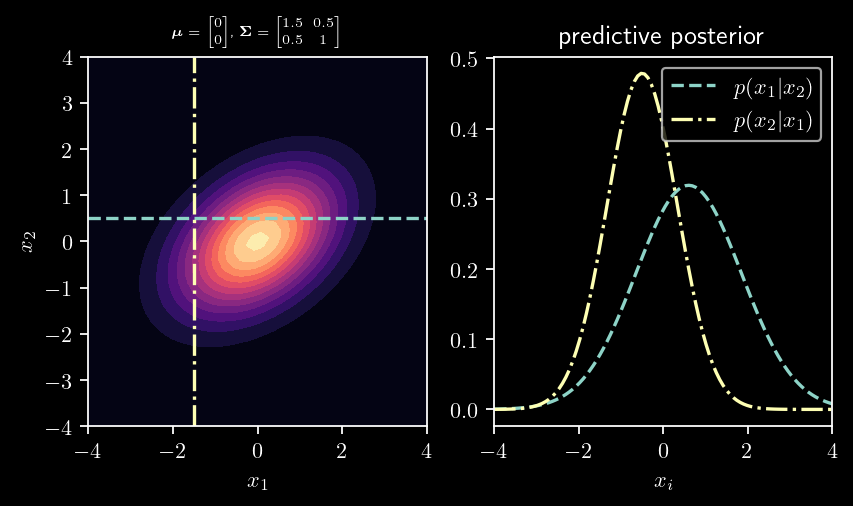

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True)

ax1.set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 0 \\ 0  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 1.5 &\hspace{-0.2cm} 0.5 \\ 0.5 &\hspace{-0.2cm} 1  \end{bmatrix}$", fontsize=6, pad=10)
mu = pt.tensor([0.0, 0.0])
sigma = pt.tensor([[1.5, 0.5], [0.5, 1]])
plot_mvg_pdf(ax1, mu.tolist(), sigma.tolist(), xx1, xx2, 0.15)
ax1.axhline(0.5, ls="--", c="C0")
ax1.axvline(-1.5, ls="-.", c="C1")
normal_1_given_2 = posterior_distribution_2D(pt.tensor(1.2), mu[0], mu[1], sigma[0, 0], sigma[0, 1], sigma[1, 1])
normal_2_given_1 = posterior_distribution_2D(pt.tensor(-1.5), mu[1], mu[0], sigma[1, 1], sigma[0, 1], sigma[0, 0])
x_plot = pt.linspace(-4, 4, 100)
p_1_2 = normal_1_given_2.log_prob(x_plot).exp()
p_2_1 = normal_2_given_1.log_prob(x_plot).exp()

ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_aspect("auto")

ax2.set_title("predictive posterior")
ax2.plot(x_plot, p_1_2, ls="--", c="C0", label=r"$p(x_1 | x_2)$")
ax2.plot(x_plot, p_2_1, ls="-.", c="C1", label=r"$p(x_2 | x_1)$")
ax2.set_xlim(-4, 4)
ax2.set_xlabel(r"$x_i$")

ax2.legend()
plt.savefig(join(output, "bivariate_gaussian.png"), dpi=320, bbox_inches="tight", transparent=True)

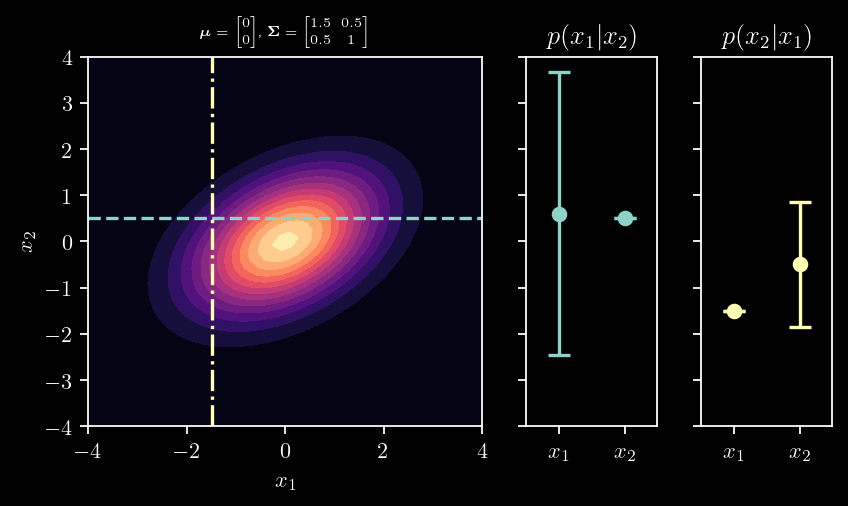

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={"width_ratios": [3, 1, 1]})

ax1.set_title(r"$\boldsymbol{\mu}=\begin{bmatrix} 0 \\ 0  \end{bmatrix}$, $\mathbf{\Sigma} = \begin{bmatrix} 1.5 &\hspace{-0.2cm} 0.5 \\ 0.5 &\hspace{-0.2cm} 1  \end{bmatrix}$", fontsize=6, pad=10)
mu = pt.tensor([0.0, 0.0])
sigma = pt.tensor([[1.5, 0.5], [0.5, 1]])
plot_mvg_pdf(ax1, mu.tolist(), sigma.tolist(), xx1, xx2, 0.15)
ax1.axhline(0.5, ls="--", c="C0")
ax1.axvline(-1.5, ls="-.", c="C1")
normal_1_given_2 = posterior_distribution_2D(pt.tensor(1.2), mu[0], mu[1], sigma[0, 0], sigma[0, 1], sigma[1, 1])
normal_2_given_1 = posterior_distribution_2D(pt.tensor(-1.5), mu[1], mu[0], sigma[1, 1], sigma[0, 1], sigma[0, 0])

ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_aspect("auto")

ax2.set_title(r"$p(x_1 | x_2)$")
ax2.errorbar([1, 2], [normal_1_given_2.mean, 0.5], yerr=[1.96*normal_1_given_2.stddev**2, 0], capsize=5, fmt="oC0", capthick=1.5)
ax3.set_title(r"$p(x_2 | x_1)$")
ax3.errorbar([1, 2], [-1.5, normal_2_given_1.mean], yerr=[0, 1.96*normal_2_given_1.stddev**2], capsize=5, fmt="oC1", capthick=1.5)

for ax in (ax2, ax3):
    ax.set_xticks([1, 2])
    ax.set_xticklabels([r"$x_1$", r"$x_2$"])
    ax.set_xlim(0.5, 2.5)
    ax.set_ylim(-4, 4)
    ax.set_yticklabels([])
plt.savefig(join(output, "bivariate_gaussian_parallel_coord.png"), dpi=320, bbox_inches="tight", transparent=True)

By increasing the number of random variables to infinity, we can approximate arbitrary smooth functions. Moreover, by sampling from this infinitely dimensional Gaussian, we sample functions from a family of functions. The precise shape that the samples can take on depends on the covariance function (kernel):
$$
    k : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}.
$$
The radial basis function (RBF) is a common kernel:
$$
  k(t_i, t_j) = \sigma^2 \mathrm{exp}\left(-\frac{|t_i - t_j|^2}{2l^2}\right),
$$
where $\sigma$ and $l$ are hyperparameters (variance and length scale).

In [11]:
def rbf_kernel(x1, x2, sigma=1.0, l=1.0):
    sqdist = pt.cdist(x1.unsqueeze(-1), x2.unsqueeze(-1), p=2).pow(2)
    return sigma**2 * pt.exp(-0.5 * sqdist / l**2)

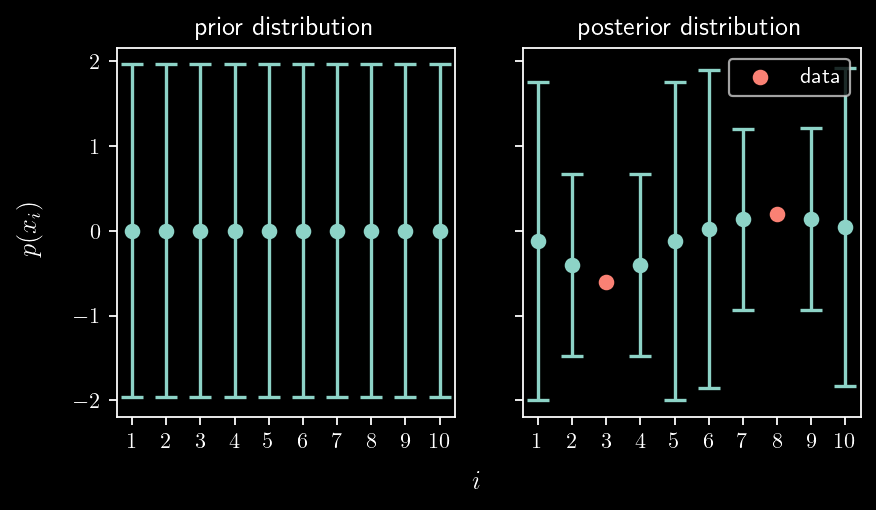

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
x = pt.linspace(-4, 4, 10)
cov = rbf_kernel(x, x)
ax1.errorbar(list(range(1, 11)), pt.zeros(10), yerr=1.96*pt.diagonal(cov), capsize=5, fmt="oC0", capthick=1.5)
ax1.set_title("prior distribution")
mask = pt.zeros(10, dtype=pt.bool)
mask[2] = True
mask[7] = True
x_train = x[mask]
sigma_bb = rbf_kernel(x_train, x_train)
x_test = x[~mask]
sigma_aa = rbf_kernel(x_test, x_test)
sigma_ab = rbf_kernel(x_train, x_test)
x_b = pt.tensor([-0.6, 0.2])
normal = posterior_distribution(x_b, pt.zeros(8), pt.zeros(2), sigma_aa, sigma_ab, sigma_bb)
where =pt.tensor(range(1, 11))[~mask]
ax2.errorbar(where, normal.mean, yerr=1.96*normal.stddev**2, capsize=5, fmt="oC0", capthick=1.5)
ax2.scatter([3, 8], x_b, c="C3", marker="o", zorder=6, label="data")
ax2.set_title("posterior distribution")
ax2.legend()

xticks = list(range(1, 11))
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)
fig.supxlabel(r"$i$", y=-0.05)
fig.supylabel(r"$p(x_i)$")
plt.savefig(join(output, "10d_gaussian_parallel_coord.png"), dpi=320, bbox_inches="tight", transparent=True)

$$
    p(x) \sim \mathcal{GP}(m(x), k(x, x^\prime))
$$
$$
    m(x) = \mathbb{E}\left[p(x)\right]
$$
$$
    k(x, x^\prime) = \mathbb{E}\left[(p(x)-m(x))(p(x^\prime) - m(x^\prime))\right]
$$

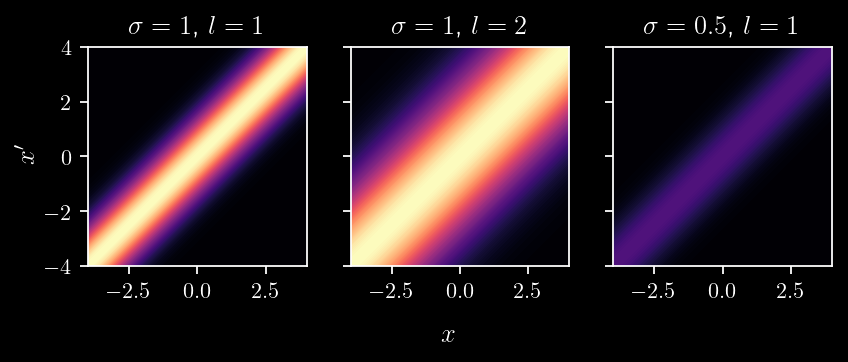

In [13]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 3), sharex=True, sharey=True)

x_plot = pt.linspace(-4, 4, 100)
vmin, vmax = 0.0, 1.0
levels = pt.linspace(vmin, vmax, 120)
props = {"levels" : levels, "vmin" : vmin, "vmax" : vmax, "cmap" : "magma"}
axarr[0].contourf(x_plot, x_plot, rbf_kernel(x_plot, x_plot), **props)
axarr[0].set_title(r"$\sigma = 1$, $l=1$")
axarr[1].contourf(x_plot, x_plot, rbf_kernel(x_plot, x_plot, l=2), **props)
axarr[1].set_title(r"$\sigma = 1$, $l=2$")
axarr[2].contourf(x_plot, x_plot, rbf_kernel(x_plot, x_plot, sigma=0.5, l=1), **props)
axarr[2].set_title(r"$\sigma = 0.5$, $l=1$")
for ax in axarr.flatten():
    ax.set_aspect("equal")
fig.supxlabel(r"$x$", y=0.1)
fig.supylabel(r"$x^\prime$", x=0.05)
plt.savefig(join(output, "rbf_kernel.png"), dpi=320, bbox_inches="tight", transparent=True)

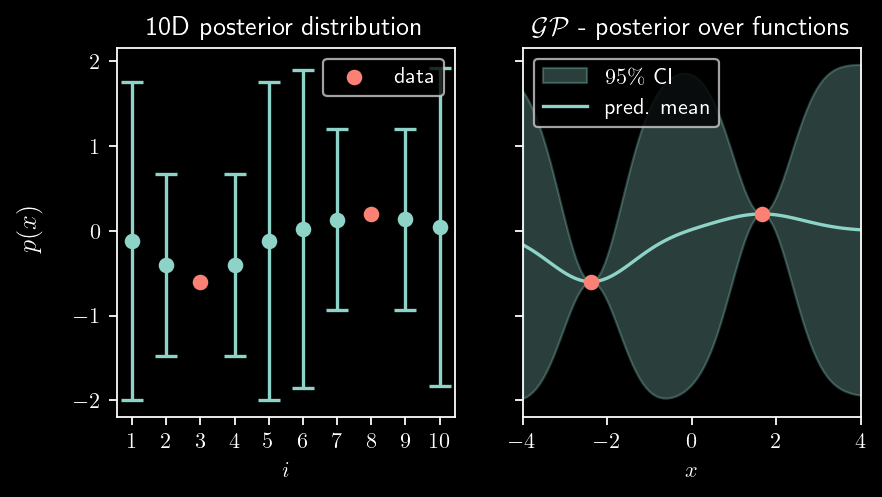

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=False, sharey=True)
x = pt.linspace(-4, 4, 10)
cov = rbf_kernel(x, x)
mask = pt.zeros(10, dtype=pt.bool)
mask[2] = True
mask[7] = True
x_train = x[mask]
sigma_bb = rbf_kernel(x_train, x_train)
x_test = x[~mask]
sigma_aa = rbf_kernel(x_test, x_test)
sigma_ab = rbf_kernel(x_train, x_test)
x_b = pt.tensor([-0.6, 0.2])
normal = posterior_distribution(x_b, pt.zeros(8), pt.zeros(2), sigma_aa, sigma_ab, sigma_bb)
where =pt.tensor(range(1, 11))[~mask]
ax1.errorbar(where, normal.mean, yerr=1.96*normal.stddev**2, capsize=5, fmt="oC0", capthick=1.5)
ax1.scatter([3, 8], x_b, c="C3", marker="o", zorder=6, label="data")
ax1.set_title("10D posterior distribution")
ax1.set_xlabel(r"$i$")
ax1.legend()
ax1.set_xticks(range(1, 11))

x = pt.linspace(-4, 4, 100)
cov = rbf_kernel(x, x)
mask = pt.zeros(100, dtype=pt.bool)
mask[20] = True
mask[70] = True
x_train = x[mask]
sigma_bb = rbf_kernel(x_train, x_train)
x_test = x[~mask]
sigma_aa = rbf_kernel(x_test, x_test)
sigma_ab = rbf_kernel(x_train, x_test)
x_b = pt.tensor([-0.6, 0.2])
normal = posterior_distribution(x_b, pt.zeros(98), pt.zeros(2), sigma_aa, sigma_ab, sigma_bb)
mean = pt.zeros_like(x)
mean[mask] = x_b
mean[~mask] = normal.mean
ci = pt.zeros_like(x)
ci[mask] = 0
ci[~mask] = 1.96 * normal.stddev**2
ax2.fill_between(x, mean-ci, mean+ci, color="C0", alpha=0.3, label="$95\%$ CI")
ax2.scatter(x[mask], x_b, c="C3", marker="o", zorder=6)
ax2.plot(x, mean, c="C0", label="pred. mean")
ax2.set_title(r"$\mathcal{GP}$ - posterior over functions")
ax2.set_xlabel(r"$x$")
ax2.set_xlim(-4, 4)
ax2.legend()
fig.supylabel(r"$p(x)$")
plt.savefig(join(output, "10d_mvg_to_gp.png"), dpi=320, bbox_inches="tight", transparent=True)

In [15]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * pt.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [16]:
# Bayesian optimization in action
# https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH05/01%20-%20BayesOpt%20loop.ipynb
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = pt.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [17]:
pt.manual_seed(0)
bound = 5
xs = pt.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)
x_train = (pt.rand((3, 1)) - 0.5) * 2 * bound
y_train = forrester_1d(x_train)

probability of improvement (POI): $a(x) = \Phi \left( \frac{\mu(x) - f_{\text{best}}}{\sigma(x)} \right)$

expected value of improvement (EVP): $a(x) = \mathbb{E} \left[ \max(0, f(x) - f_{\text{best}}) \right]$

upper confidence interval (UCI): $a(x) = \mu(x) + \beta \sigma(x)$

In [26]:
model, likelihood = fit_gp_model(x_train, y_train)
ucb_policy = botorch.acquisition.analytic.UpperConfidenceBound(model, beta=0.5)
poi_policy = botorch.acquisition.analytic.ProbabilityOfImprovement(model, best_f=y_train.max(), maximize=True)
ei_policy = botorch.acquisition.analytic.LogExpectedImprovement(model, best_f=y_train.max(), maximize=True)

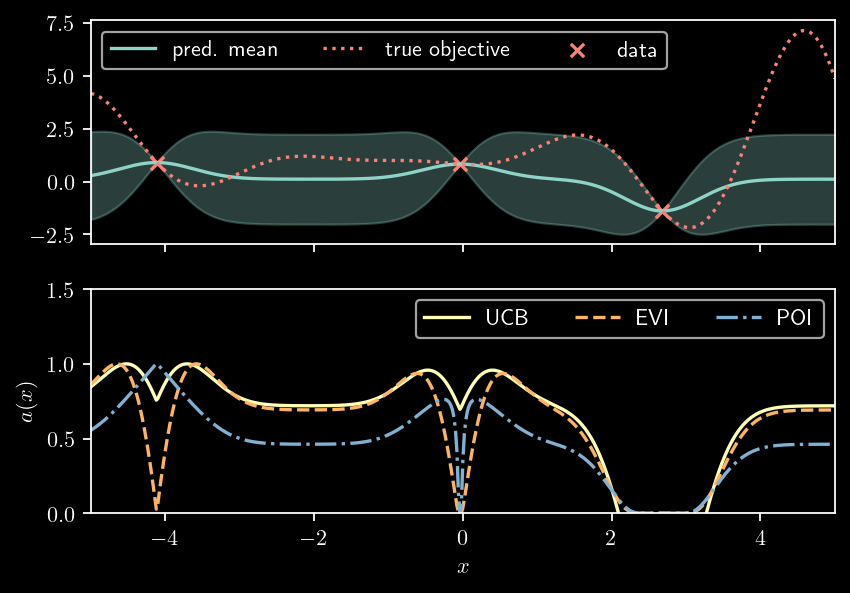

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 4), sharex=True)

with pt.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()
    ucb_acquisition_score = ucb_policy(xs.unsqueeze(-1))
    poi_acquisition_score = poi_policy(xs.unsqueeze(-1))
    ei_acquisition_score = ei_policy(xs.unsqueeze(-1)).exp()

ax1.fill_between(xs.squeeze(), predictive_lower, predictive_upper, color="C0", alpha=0.3)
ax1.plot(xs, predictive_mean, c="C0", label="pred. mean")
ax1.plot(xs, ys, c="C3", ls=":", label="true objective")
ax1.scatter(x_train, y_train, marker="x", c="C3", label="data")
ax1.set_xlim(-bound, bound)
ax1.legend(ncol=3)

ax2.plot(xs.squeeze(), ucb_acquisition_score/ucb_acquisition_score.max(), c="C1", label="UCB")
ax2.plot(xs.squeeze(), ei_acquisition_score/ei_acquisition_score.max(), c="C5", ls="--", label="EVI")
ax2.plot(xs.squeeze(), poi_acquisition_score/poi_acquisition_score.max(), c="C4", ls="-.", label="POI")
ax2.legend(ncol=3)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$a(x)$")
ax2.set_ylim(0, 1.5)
plt.savefig(join(output, "policy_comparison.png"), dpi=320, bbox_inches="tight", transparent=True)